# About This Notebook

# Testing efficiency of GpyTorch

**In this notebook we will test computational efficiency of GPyTorch by varying the following parameters: number of pool points and dimensionality of the input points. There will be several experiments.**

# Task: 
**Написать функцию, которая берет на вход train_set, pool_set и 
а) строит ГП на train_set, 
б) делает UE для pool_set**

In [1]:
from matplotlib import image
from matplotlib.pyplot import imread
from IPython import display

import os
import time
import math
from copy import deepcopy
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.optimize import rosen

# Visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

# To plot in offline 
plotly.offline.init_notebook_mode(connected=True)


# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import gpytorch
torch.random.manual_seed(123456)

# Required Functions for model and training

In [2]:
class GPyTorch_Framework():
    
    def __init__(self, X_train, y_train):
        
        self.X_train = X_train
        self.y_train = y_train
        
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gp_model = GPRegressionModel(self.X_train, self.y_train, self.likelihood)
        
        
    def train(self, optimizer, mll_loss, num_iters, print_iter = True):
        
        self.gp_model.train()
        self.likelihood.train()
        
        start_time = time.time()
        
        for i in range(num_iters):

            optimizer.zero_grad()
            output = self.gp_model(self.X_train)
            loss = -mll_loss(output, self.y_train)
            loss.backward()
            optimizer.step()    
            
            # Then we print the results for this epoch:
            if print_iter:
                print('Iter %d/%d -MLL Loss: %.3f' % (i + 1, num_iters, loss.item()))
        
        # TODO 
        # It is not a good idea to safe time in that way, because 
        # we will have irrelevant time when will decide to fine-train model for several epochs
        self.training_time = time.time() - start_time
        
    
    def predict_simple(self, X_pool):
       
        # Set into eval mode
        self.gp_model.eval()
        self.likelihood.eval()

        with torch.no_grad():
            start_time = time.time()
            preds = self.gp_model(X_pool)
            exact_covar = preds.covariance_matrix
            exact_covar_time = time.time() - start_time
            
        return preds, exact_covar, exact_covar_time
    
    
    def predict_fast(self, X_pool, max_root_size):
       
        #TODO
        # We need to find out the difference between
        # fast prediction with and without cashe
        
        # Set into eval mode
        self.gp_model.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var(), \
                                        gpytorch.settings.max_root_decomposition_size(max_root_size):
            
            start_time = time.time()
            preds = self.gp_model(X_pool)
            fast_covar = preds.covariance_matrix
            fast_covar_time = time.time() - start_time
            
        return preds, fast_covar, fast_covar_time

In [3]:
def calculate_metrics_of_similarity(exact_covar, fast_covar):
    
    mae = (exact_covar - fast_covar).abs().mean()
    sq_norm = (exact_covar - fast_covar).norm()
    
    return mae, sq_norm

In [4]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, X_train, y_train, likelihood):
            super(GPRegressionModel, self).__init__(X_train, y_train, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            )
            
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
def generate_Rosenbrock_Problem(num_points, num_dims):
    
    X = np.random.random((num_points, num_dims))
    y = rosen(X.T)
    
    return (torch.Tensor(X), torch.Tensor(y))

# Experiment 0
**Just check that everything is fine.**

# Generating Data

In [6]:
np.random.seed(123)

num_train_points = 100
num_pool_points = 100
num_dims = 5

X_train, y_train = generate_Rosenbrock_Problem(num_train_points, num_dims)
X_pool, y_pool = generate_Rosenbrock_Problem(num_pool_points, num_dims)

X_train.shape, y_train.shape, X_pool.shape, y_pool.shape

(torch.Size([100, 5]),
 torch.Size([100]),
 torch.Size([100, 5]),
 torch.Size([100]))

# Training and Prediction

In [7]:
gpy_torch_framework = GPyTorch_Framework(X_train, y_train)

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': gpy_torch_framework.gp_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(gpy_torch_framework.likelihood, gpy_torch_framework.gp_model)

In [8]:
predictions, covar_matrix, pred_time = gpy_torch_framework.predict_simple(X_pool)
print("MAE: ", (predictions.mean - y_pool).abs().mean().item())

MAE:  26.5147705078125


In [10]:
gpy_torch_framework.train(optimizer, mll, 50, print_iter = True)

predictions, exact_covar_matrix, pred_time = gpy_torch_framework.predict_simple(X_pool)
fast_predictions, fast_covar_matrix, fast_pred_time = gpy_torch_framework.predict_fast(X_pool, 50)


print("MAE between predictions and true labels: {}".format( 
                          (predictions.mean - y_pool).abs().mean().item()))

print("Time simple: ", pred_time)
print("Time fast: ", fast_pred_time)

mae, sq_norm = calculate_metrics_of_similarity(exact_covar_matrix, fast_covar_matrix)


# TODO 
# Such calculating is not really relevant, because we need to take into account the sizes of matrices

print('MAE between exact covar matrix and fast covar matrix: {}'.format(mae))
print('Squared Norm between exact covar matrix and fast covar matrix: {}'.format(sq_norm))

Iter 1/50 -MLL Loss: 882.103
Iter 2/50 -MLL Loss: 810.552
Iter 3/50 -MLL Loss: 750.180
Iter 4/50 -MLL Loss: 700.232
Iter 5/50 -MLL Loss: 657.967
Iter 6/50 -MLL Loss: 619.441
Iter 7/50 -MLL Loss: 582.815
Iter 8/50 -MLL Loss: 548.437
Iter 9/50 -MLL Loss: 517.024
Iter 10/50 -MLL Loss: 488.882
Iter 11/50 -MLL Loss: 463.911
Iter 12/50 -MLL Loss: 441.704
Iter 13/50 -MLL Loss: 421.752
Iter 14/50 -MLL Loss: 403.659
Iter 15/50 -MLL Loss: 387.030
Iter 16/50 -MLL Loss: 371.693
Iter 17/50 -MLL Loss: 357.483
Iter 18/50 -MLL Loss: 344.323
Iter 19/50 -MLL Loss: 332.147
Iter 20/50 -MLL Loss: 320.941
Iter 21/50 -MLL Loss: 310.634
Iter 22/50 -MLL Loss: 301.185
Iter 23/50 -MLL Loss: 292.538
Iter 24/50 -MLL Loss: 284.598
Iter 25/50 -MLL Loss: 277.250
Iter 26/50 -MLL Loss: 270.443
Iter 27/50 -MLL Loss: 264.068
Iter 28/50 -MLL Loss: 258.096
Iter 29/50 -MLL Loss: 252.461
Iter 30/50 -MLL Loss: 247.125
Iter 31/50 -MLL Loss: 242.109
Iter 32/50 -MLL Loss: 237.394
Iter 33/50 -MLL Loss: 232.953
Iter 34/50 -MLL Los

**As we can see, all functions works in the right way. As we can see, predictions with LOVE needed less time for computing them with a big MAE accuracy.**

**And now we can write main loop for experiment, in which we compare the computational efficiency of these methods on data with different number of training points and dimnensionality of input points.**

# Experiment 1:

**In this experiment, we compare time of evaluation of covariance matrix for Test set using two approaches: without and with LOVE. We will use implemented in Gpytorch models, based on "Constant-Time Predictions for GP" article.:**

In [11]:
dimensions_ar = np.arange(5, 26, 6, dtype=np.int64)
dimensions_ar

array([ 5, 11, 17, 23])

In [12]:
#num_pool_points_ar = np.logspace(1, 5, 5, dtype=np.int64)
num_points_ar = [10, 100, 200, 500, 1000, 2000, 3500]
#num_train_points_ar = [10, 100, 200, 500, 1000, 2000, 5000]
num_points_ar

[10, 100, 200, 500, 1000, 2000, 3500]

In [13]:
#dimensions_ar = [2, 4, 6]
#num_points_ar = [10, 20, 30]

In [14]:
num_iters = 25

time_training = {}
time_simple_results = {}
time_fast_results = {}

mae_scores_results = {}
sq_norm_scores_results = {}

for num_dims in tqdm_notebook(dimensions_ar):
    
    cur_time_training = []
    cur_time_simple = []
    cur_time_fast = []
    
    cur_mae = []
    cur_sq_norm = []
    
    for num_points in tqdm_notebook(num_points_ar):
        
        X_train, y_train = generate_Rosenbrock_Problem(num_points, num_dims)
        X_pool, y_pool = generate_Rosenbrock_Problem(num_points, num_dims)
        
        gpy_torch_framework = GPyTorch_Framework(X_train, y_train)
    
        optimizer = torch.optim.Adam([{'params': gpy_torch_framework.gp_model.parameters()}], lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(gpy_torch_framework.likelihood, 
                                                               gpy_torch_framework.gp_model)
        
        
        gpy_torch_framework.train(optimizer, mll, 50, print_iter = False)

        predictions, exact_covar_matrix, pred_time = gpy_torch_framework.predict_simple(X_pool)
        fast_predictions, fast_covar_matrix, fast_pred_time = gpy_torch_framework.predict_fast(X_pool, 50)
        
        
        mae, sq_norm = calculate_metrics_of_similarity(exact_covar_matrix, fast_covar_matrix)
        
        cur_time_training.append(gpy_torch_framework.training_time)
        cur_time_simple.append(pred_time)
        cur_time_fast.append(fast_pred_time)
        
        cur_mae.append(mae)
        cur_sq_norm.append(sq_norm)
        
    time_training[num_dims] = cur_time_training
    time_simple_results[num_dims] = cur_time_simple
    time_fast_results[num_dims] = cur_time_fast

    mae_scores_results[num_dims] = cur_mae
    sq_norm_scores_results[num_dims] = cur_sq_norm

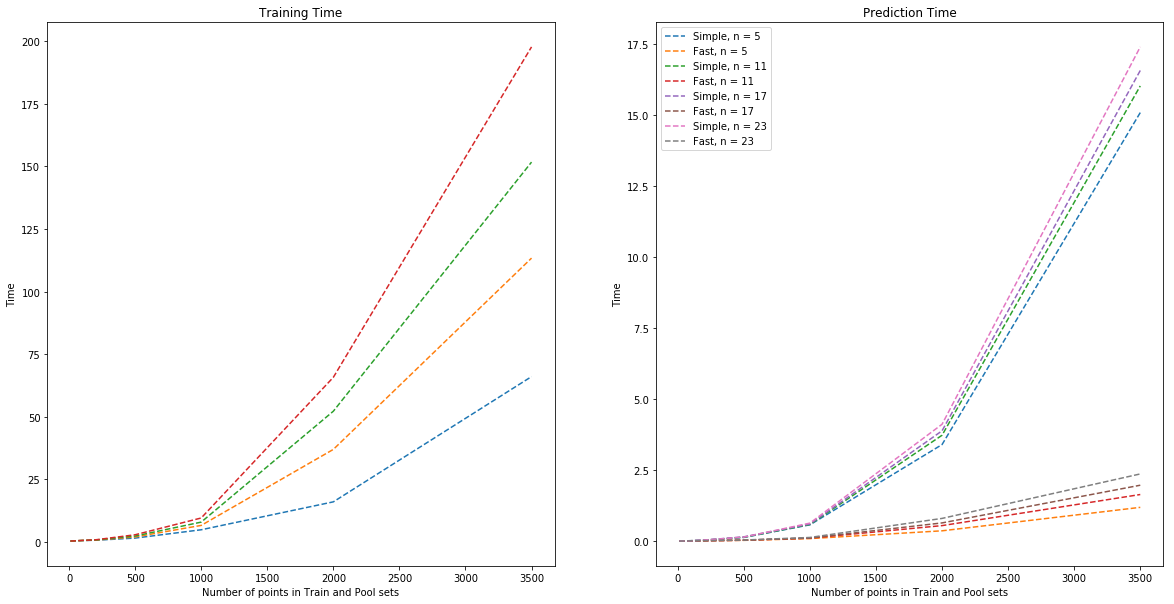

In [45]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(121)
ax1.set_title("Training Time")
ax1.set_xlabel("Number of points in Train and Pool sets")
ax1.set_ylabel("Time")

for num_dims in dimensions_ar:
    ax1.plot(num_points_ar, time_training[num_dims], ls = '--', label = "n = {}".format(num_dims))

    
ax2 = fig.add_subplot(122)
ax2.set_title("Prediction Time")
ax2.set_xlabel("Number of points in Train and Pool sets")
ax2.set_ylabel("Time")


for num_dims in dimensions_ar:
    ax2.plot(num_points_ar, time_simple_results[num_dims], ls = '--', label = "Simple, n = {}".format(num_dims))
    ax2.plot(num_points_ar, time_fast_results[num_dims], ls = '--', label = "Fast, n = {}".format(num_dims))

plt.xlabel("Number of points in Train and Pool sets")
plt.ylabel("Time")
plt.legend()
plt.show()